# Modern Portfolio Theory

In [143]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

### Importing the Data

We begin our analysis by importing a year's worth of data for the popular FAANG stocks plus Microsoft using yahoo finance API.  

In [22]:
prices = []
for i in ['FB', 'AAPL',  'AMZN', 'GOOG',  'NFLX', 'MSFT']:
    df_1 = pdr.DataReader(i, 'yahoo', 2019, 2021)
    df_1['symbol'] = i
    prices.append(df_1)
prices = pd.concat(prices)

prices.rename(columns={'Close':'close', 'High':'high', 'Low':'low', 'Open':'open', 'Volume':'volume', 'symbol':'ticker'}, inplace=True)

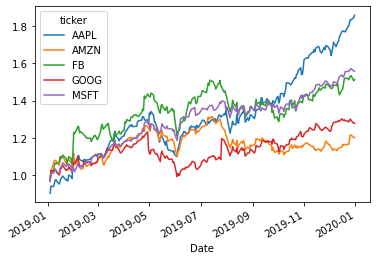

In [118]:
close = prices.pivot(columns='ticker', values='close').pct_change().loc['2019'] + 1
close.cumprod().plot()

As one might think, the correlations between this set of stocks is relatively high. 

In [119]:
close.corr().round(2)

ticker,AAPL,AMZN,FB,GOOG,MSFT
ticker,,,,,
AAPL,1.00,0.59,0.48,0.56,0.62
AMZN,0.59,1.00,0.62,0.61,0.72
FB,0.48,0.62,1.00,0.57,0.53
GOOG,0.56,0.61,0.57,1.00,0.63
MSFT,0.62,0.72,0.53,0.63,1.00


### Portfolio Level Return and Volatility

Given that we are interested in portfolio level mean and voatility, we need to produce the formulas that determine these quantities. Let $\mathbf{w}$ be the vector of weights assigned to each portfolio constituent and $\mathbf{r}$ be the vector of expected constituent returns. Thus, we get the expecterd return of the porfolio:


$ \mathbf{E}[r_{p}] = \mathbf{E}[\mathbf{w}^\top \cdot \mathbf{r}] = \mathbf{w}^\top \cdot \mathbf{E}[\mathbf{r}]$,

where $\cdot$ refers to the dot product between the return and weights vectors $\mathbf{r}$ and $\mathbf{w}$ respectively. 

The second object of modern portfolio theory is volatility, i.e. portfolio level standard deviation.
This can be conveniently computed using the covariance matrix of the portfolio constituents and weights as follows:

$\sigma_p = \sqrt{\sigma_p^2}$, where 

$\sigma_{p}^2 = \mathbf{E}[(\mathbf{r} - \mathbf{E}[\mathbf{r}])^2] = \sum_i \sum_j w_i w_j \sigma_{i,j} =  \mathbf{w}^\top \Sigma_p \mathbf{w}$,

For an euqually weighted portfolio with constraints 

$ \sum_i w_i = 1$ and $w_i \geq 0 \ \forall i$

we have the following portfolio level annualized volatility given the selection of stocks above:

In [443]:
noa = close.shape[1]
w = np.array([1 / close.shape[1] for i in range(0, noa)])
portfolio_vol = (w.dot(close.cov().dot(w))*252)**0.5

print(str(np.round(portfolio_vol*100, 2)) + '%')

19.78%


Of paramount importance for investors is the risk-return profile of the portfolio. This figure is generally referred to as the Sharpe ratio and it measures how many units of return per unit of risk the portfolio produces (here by risk me mean percentage volatility and by return we mean percentage return):

$SR = \frac{r_p}{\sigma_p}$.

We proceed to generate a Monte Carlo simulation for portfolio wieghts to highlight how the risk-return relationship, i.e. Sharpe ratio, changes when randomly sampling portfolio weights. 

In [397]:
ret_p = (close.prod() -1)
vol_p = (close.var()*252)**0.5
S = close.cov()

port_rets = []
port_vols = []
port_sr = []
for i in range(1, 5000):
    w = np.random.random(noa)
    w /= np.sum(w)
    
    p_r = (ret_p*w).sum()
    p_v = (w.T.dot(S.dot(w))*252)**0.5
    p_sr = p_r/p_v
    
    
    port_rets.append(p_r)
    port_vols.append(p_v)
    port_sr.append(p_sr)

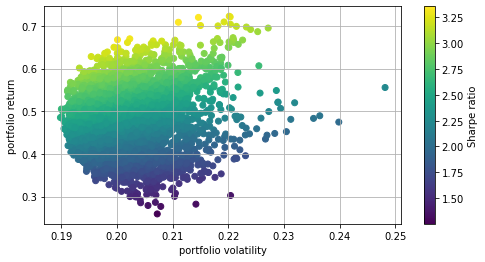

In [399]:
plt.figure(figsize=(8, 4))
plt.scatter(port_vols, port_rets, c= port_sr, marker='o')
plt.grid(True)
plt.xlabel('portfolio volatility')
plt.ylabel('portfolio return')
plt.colorbar(label='Sharpe ratio')

As an investor one clearly chooses the highest Sharpe ratio portfolio for a chosen level of risk. For example, for a 0.2 volatility portfolio there are multiple portfolios to choose from. The set of portfolios that give the maximum return for a given amount of risk is called the efficient frontier. This is the outmost boundary in the scatterplot. We proceed to produce this set of portfolio via an optimization scheme. 

### Portfolio Optimization and the Efficient Frontier 

We proceed to generate an optimization scheme which produces the highest Sharpe ratio portfolio, the minimum volatility portfolio, as well as the complete efficient frontier. This is done via a convex optimization program with a given objective function and set of constraints and bounds. We begin by defining a helper function to make the program more neat, the necessary boundary conditions and constraints, as well as the optimization scheme. The whole analysis is conducted upon the Monte Carlo analysis above.

In [418]:
def port_quants(w):
    '''Returns portfolio level quantities: return, volatility, Sharpe ratio
    
    Parameters
    ==========
    w : np.array
        portfolio weights
    r : pd.Series
        portfolio returns
    S : pd.DataFrame
        covariance matrix for portfolio constituents
    
    Returns
    =======
    port_ret : float
        portfolio level return
    port_vol : float
        portfolio level volatility
    sr : float
        portfolio Sharpe ratio
    '''
    port_ret = (ret_p*w).sum()
    port_vol =  (w.T.dot(S.dot(w))*252)**0.5
    sr = port_ret / port_vol
    
    return pd.Series([port_ret, port_vol, sr], index=['port_ret', 'port_vol', 'sr'])

def optimal_sr(w):
    return -port_quants(w)['sr']

def optimal_vol(w):
    return port_quants(w)['port_vol']

In [440]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))


# Max Sharpe ratio portfolio
opts = sco.minimize(optimal_sr, # objective function
                    noa * [1. / noa,], # initial conditions
                    method='SLSQP',  # optimization algorithm 
                    bounds=bnds, 
                    constraints=cons) 
max_sr_w = opts['x']
max_sr_vol = (w.T.dot(S.dot(max_sr_w))*252)**0.5
max_sr_r = (ret_p*max_sr_w).sum()
max_sr_sr = max_sr_r/max_sr_vol

# Minimum volatility portfolio
opts = sco.minimize(optimal_vol, # objective function
                    noa * [1. / noa,], # initial conditions
                    method='SLSQP',  # optimization algorithm 
                    bounds=bnds, 
                    constraints=cons) 
min_vol_w = opts['x']
min_vol_vol = (w.T.dot(S.dot(min_vol_w))*252)**0.5
min_vol_r = (ret_p*min_vol_w).sum()
min_vol_sr = min_vol_r/min_vol_vol

The set of optimal portfolios for a given set of portfolio level returns is referred to as the efficient frontier. Here by optimality we mean highest Sharpe ratio portfolio. This is done by iterating over a set of constraints which is determined by the set of portfolio returns. I.e. we add ab extra constraint by specifying the return target.

In [436]:
targets = np.linspace(ret_p.min(), ret_p.max(), 100)

port_opt_vol = []
port_opt_ret = []
port_opt_sr = []
for i in targets:
    cons = ({'type': 'eq', 'fun': lambda x: port_quants(x)['port_ret'] - i},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for x in range(noa))
    res = sco.minimize(optimal_vol,
                       noa * [1. / noa,], 
                       method='SLSQP',
                       bounds=bnds, 
                       constraints=cons)
    w = res['x']
    
    vol = (w.T.dot(S.dot(w))*252)**0.5
    r = (ret_p*w).sum()
    sr = r/vol
    
    port_opt_vol.append(vol)
    port_opt_ret.append(r)
    port_opt_sr.append(sr)

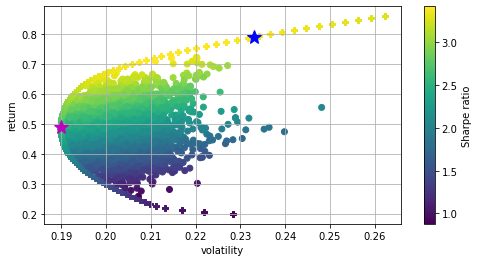

In [442]:
plt.figure(figsize=(8, 4))

# MC portfolio compositions
plt.scatter(port_vols, port_rets, c= port_sr, marker='o')

# efficient frontier
plt.scatter(port_opt_vol, port_opt_ret, c=port_opt_sr, marker='P')

# portfolio with highest Sharpe ratio
plt.plot(max_sr_vol, max_sr_r+0.05, 'b*', markersize=15)

# minimum variance portfolio
plt.plot(min_vol_vol, min_vol_r, 'm*', markersize=15)

plt.grid(True)
plt.xlabel('volatility')
plt.ylabel('return')
plt.colorbar(label='Sharpe ratio')

Above we see the Monte Carlo scatter plot, the efficient frontier as well as the minimum volatility portfolio (purple star) and the maximum Sharpe ratio portfolio (blue star). This is the main corpus of modern portfolio theory. I will be extending the theory via a Bayesian approach to cover what one might consider the "post-modern portfolio theory."